In [51]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

In [52]:
# Check if the GPU is available
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")


GPU is not available


In [53]:
# Directory where the images are stored
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'


In [54]:
# Function for uploading and resizing images
def load_image(image_path, target_size=(56, 56)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  
        return np.array(image) / 255.0  
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [55]:
# Load training group IDs
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\higher_resolution_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [56]:
# Load validation group IDs
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\higher_resolution_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [57]:
%%capture
# Lists for storing image paths and corresponding labels
train_data = []
val_data = []

# Iterate over all the files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [58]:
# Check the number of images uploaded
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 5240
Número de imagens de validação carregadas: 1746


In [59]:
# Separate images and labels
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

In [60]:
val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [61]:
# Upload images
train_images = [load_image(image_path, target_size=(56, 56)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(56, 56)) for image_path in val_images]

In [64]:
# Check if an image has failed to load
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [65]:
# Convert the labels to the appropriate format (numeric)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [66]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Use sparse_output no lugar de sparse
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Adjust the encoder on the training labels and turn them into one-hot encoding
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))

# Transform validation labels
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

In [67]:
# Define a personalised data generator
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=16, target_size=(56, 56)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [load_image(self.image_paths[i], self.target_size) for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [68]:
# Create generators for training and validation
train_generator = DataGenerator(train_images, train_labels_one_hot, batch_size=16)
val_generator = DataGenerator(val_images, val_labels_one_hot, batch_size=16)

In [69]:
# Load the ResNet50 base model with pre-trained weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(56, 56, 3))

In [70]:
# Freeze ResNet50 layers to train only customised layers
base_model.trainable = False

In [71]:
# Add new layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [72]:
# create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [73]:
# Fine-tuning 
# Defrost the last layers of ResNet50 for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [74]:
#Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [100]:
# Continue training with fine-tuning
history_finetune = model.fit(
    np.array(train_images), 
    train_labels_one_hot, 
    epochs=20, 
    batch_size=16, 
    validation_data=(np.array(val_images), val_labels_one_hot)
)

Epoch 1/20
328/328 [==============================] - 147s 446ms/step - loss: 1.1667 - accuracy: 0.5109 - val_loss: 1.1762 - val_accuracy: 0.5017
Epoch 2/20
328/328 [==============================] - 134s 410ms/step - loss: 1.1624 - accuracy: 0.5095 - val_loss: 1.1562 - val_accuracy: 0.5149
Epoch 3/20
328/328 [==============================] - 132s 403ms/step - loss: 1.1391 - accuracy: 0.5239 - val_loss: 1.1765 - val_accuracy: 0.5017
Epoch 4/20
328/328 [==============================] - 139s 424ms/step - loss: 1.1463 - accuracy: 0.5145 - val_loss: 1.1256 - val_accuracy: 0.5418
Epoch 5/20
328/328 [==============================] - 145s 442ms/step - loss: 1.1287 - accuracy: 0.5315 - val_loss: 1.1956 - val_accuracy: 0.5011
Epoch 6/20
328/328 [==============================] - 141s 431ms/step - loss: 1.1203 - accuracy: 0.5288 - val_loss: 1.1264 - val_accuracy: 0.5384
Epoch 7/20
328/328 [==============================] - 140s 426ms/step - loss: 1.1182 - accuracy: 0.5330 - val_loss: 1.1745 -

In [101]:
#save the model
model.save('trained_model.resnet_higher_resolution')

INFO:tensorflow:Assets written to: trained_model.resnet_higher_resolution\assets


INFO:tensorflow:Assets written to: trained_model.resnet_higher_resolution\assets


In [102]:
# Evaluate in the validation set
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

55/55 [==============================] - 13s 241ms/step - loss: 1.0970 - accuracy: 0.5389
Loss no conjunto de validação: 1.0970485210418701
Accuracy no conjunto de validação: 0.5389461517333984


In [103]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions from the model
val_predictions = model.predict(np.array(val_images))

# Convert one-hot encoded predictions to labels
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Classification report
target_names = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

55/55 [==============================] - 15s 240ms/step
Matriz de Confusão:
[[ 14  43  31  70  21]
 [  4 219  17  91  37]
 [  8  45 250 111  18]
 [  3  57  46 346  19]
 [  7  63  32  82 112]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.39      0.08      0.13       179
    Classe 1       0.51      0.60      0.55       368
    Classe 2       0.66      0.58      0.62       432
    Classe 3       0.49      0.73      0.59       471
    Classe 4       0.54      0.38      0.45       296

    accuracy                           0.54      1746
   macro avg       0.52      0.47      0.47      1746
weighted avg       0.54      0.54      0.52      1746



In [104]:
# Save the confusion matrix and the classification report
np.save('confusion_matrix.npy', conf_matrix)

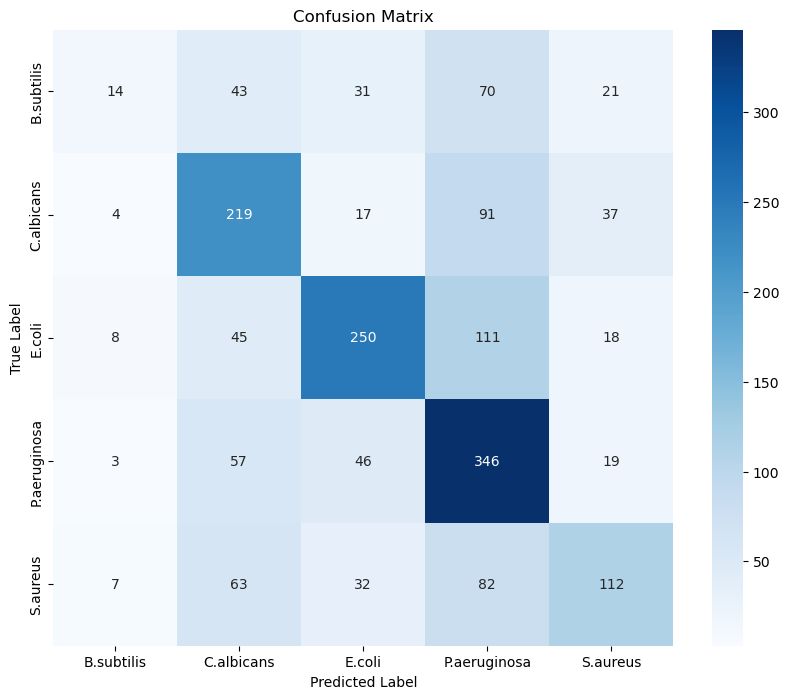

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualise the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtain probability forecasts from the model
val_predictions_prob = model.predict(np.array(val_images))

55/55 [==============================] - 11s 190ms/step


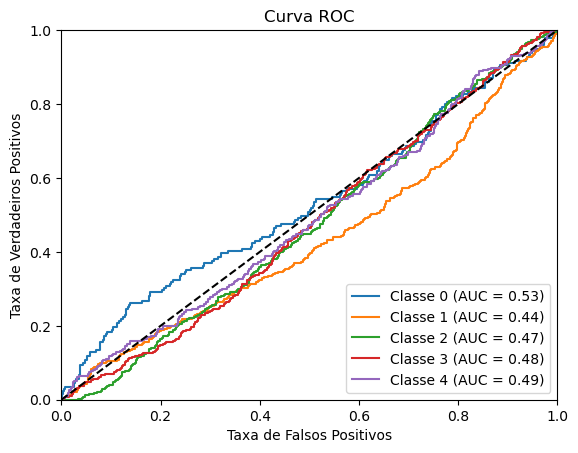

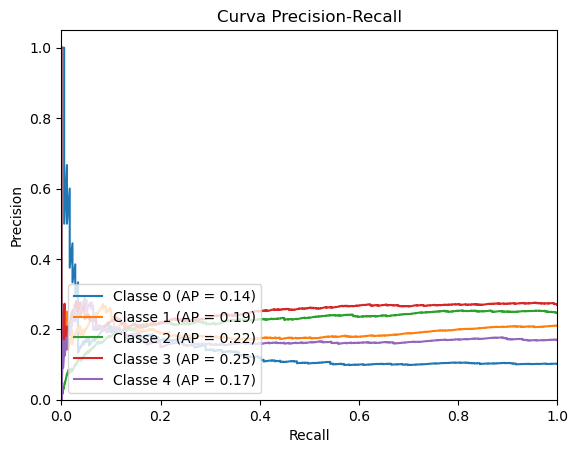

In [83]:
# Number of classes
n_classes = val_labels_one_hot.shape[1]

# Roc curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(val_labels_one_hot[:, i], val_predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall and Average Precision curves
precision = dict()
recall = dict()
pr_auc = dict()
ap = dict()  # # Dictionary to store the AP

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(val_labels_one_hot[:, i], val_predictions_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    ap[i] = average_precision_score(val_labels_one_hot[:, i], val_predictions_prob[:, i])  # Calcular AP

# Plot the Precision-Recall curve
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Classe {i} (AP = {ap[i]:.2f})')  # Exibir AP no label
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower left")
plt.show()